In [1]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

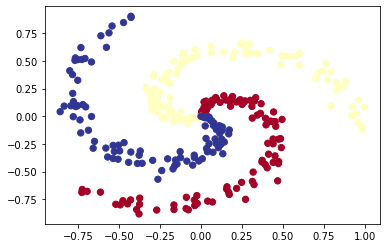

In [2]:
# Code for creating a spiral dataset
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [3]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [4]:
# Let's calculuate the accuracy for when we fit our model
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [5]:
from torch import nn

# Create model by subclassing nn.Module
class SpiralModel(nn.Module):
  def __init__(self, input_features, hidden_units, output_features):
    super().__init__()

  ## VERSION 1
    self.linear_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_stack(x)

  ## VERSION 2
  #   self.linear1 = nn.Linear(in_features=2, out_features=10)
  #   self.linear2 = nn.Linear(in_features=10, out_features=10)
  #   self.linear3 = nn.Linear(in_features=10, out_features=3)
  #   self.relu = nn.ReLU()

  # def forward(self, x):
  #   return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

# Instantiate model and send it to device
my_model = SpiralModel(input_features=2, hidden_units=10, output_features=4).to(device)
my_model

SpiralModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [6]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out first 10 untrained model outputs (forward pass)
y_logits = my_model(X_train)
print("Logits: ", y_logits[:5])

y_pred_probs = torch.softmax(y_logits, dim=1)
print("Pred probs: ", y_pred_probs[:5])

y_pred_labels = torch.argmax(y_pred_probs, dim=1)
print("Pred labels: ", y_pred_labels[:5])

torch.float32 torch.float32 torch.int64 torch.int64
Logits:  tensor([[ 0.3263, -0.0366,  0.2115,  0.2870],
        [ 0.3225, -0.0458,  0.2119,  0.2953],
        [ 0.3129, -0.0562,  0.1955,  0.2552],
        [ 0.3376, -0.0687,  0.1805,  0.2663],
        [ 0.3235, -0.0762,  0.1770,  0.2329]], grad_fn=<SliceBackward>)
Pred probs:  tensor([[0.2818, 0.1960, 0.2512, 0.2709],
        [0.2809, 0.1943, 0.2515, 0.2733],
        [0.2837, 0.1962, 0.2523, 0.2678],
        [0.2897, 0.1930, 0.2476, 0.2698],
        [0.2901, 0.1945, 0.2505, 0.2649]], grad_fn=<SliceBackward>)
Pred labels:  tensor([0, 0, 0, 0, 0])


In [7]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=my_model.parameters(), lr=0.01)

In [8]:
# Build a training loop for the model
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
EPOCHS = 1000

for epoch in range(1, EPOCHS+1):

  ## Training
  my_model.train()

  # 1. Forward pass
  y_logits = my_model(X_train)
  y_pred_prob = torch.softmax(y_logits, dim=1)
  y_pred_label = y_pred_prob.argmax(dim=1)

  # print(y_pred_label.dtype, y_train.dtype)

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred_label, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  my_model.eval()
  with torch.inference_mode():
    # 1. Forward pass
      y_test_logits = my_model(X_test)
      y_test_pred = torch.softmax(y_test_logits, dim=1)
      y_test_pred_label = y_test_pred.argmax(dim=1)

    # 2. Caculate loss and acc
      test_loss = loss_fn(y_test_logits, y_test)
      test_acc = acc_fn(y_test_pred_label, y_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 100 | Loss: 0.34147, Acc: 0.86% | Test Loss: 0.35839, Test Acc: 0.88%
Epoch: 200 | Loss: 0.09050, Acc: 0.98% | Test Loss: 0.06888, Test Acc: 1.00%
Epoch: 300 | Loss: 0.04463, Acc: 0.99% | Test Loss: 0.01847, Test Acc: 1.00%
Epoch: 400 | Loss: 0.02957, Acc: 0.99% | Test Loss: 0.00452, Test Acc: 1.00%
Epoch: 500 | Loss: 0.02375, Acc: 0.99% | Test Loss: 0.00171, Test Acc: 1.00%
Epoch: 600 | Loss: 0.02085, Acc: 0.99% | Test Loss: 0.00094, Test Acc: 1.00%
Epoch: 700 | Loss: 0.01901, Acc: 0.99% | Test Loss: 0.00055, Test Acc: 1.00%
Epoch: 800 | Loss: 0.01772, Acc: 0.99% | Test Loss: 0.00042, Test Acc: 1.00%
Epoch: 900 | Loss: 0.01679, Acc: 0.99% | Test Loss: 0.00090, Test Acc: 1.00%
Epoch: 1000 | Loss: 0.01612, Acc: 0.99% | Test Loss: 0.00079, Test Acc: 1.00%


In [9]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

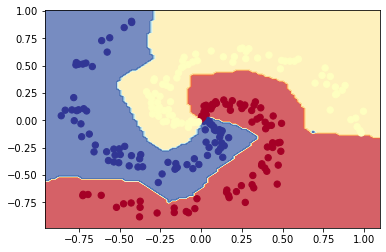

In [10]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(my_model, X_train, y_train)